In [1]:
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.api as sm
import scipy
import brmbs.data.DataLoader as dl

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1. Read and Clean Data

## 1.1.  Import and plot bechmark rates

In [2]:
df, TBAs, params, all_coupons, rate_Base_raw, FN_issue, rate_Base = dl.load_all_data(data_folder = 'data/')

def dtToIndex(date):
    return date.strftime("%Y-%m-%d")

## 1.2. Find top three issued coupon in each period

In [3]:
Most_issue = []
Second_Most_issued = []
Third_Most_issued = []
for i in FN_issue.index:
    tmp = FN_issue.loc[i]
    fst_max = np.argmax(tmp)
    tmp = tmp.drop(fst_max)
    sec_max = np.argmax(tmp)
    tmp = tmp.drop(sec_max)
    trd_max = np.argmax(tmp)
    Most_issue.append(float(fst_max.split()[4][:-1]))
    Second_Most_issued.append(float(sec_max.split()[4][:-1]))
    Third_Most_issued.append(float(trd_max.split()[4][:-1]))
    
most_issued_list = pd.DataFrame({'Mostly Issued' : Most_issue, 'Secondly Issued' : Second_Most_issued, \
                                 'Thirdly Issued' : Third_Most_issued}, index = FN_issue.index)

In [4]:
date_index = np.unique(df.index)
date_index = date_index[date_index >= np.datetime64(dt.datetime.strptime(FN_issue.index[0], '%d-%b-%y'))]
issue_dist = pd.DataFrame(np.zeros((len(date_index), FN_issue.shape[1])), index = date_index, columns = all_coupons)

for d in most_issued_list.index:
    m_end = dt.datetime.strptime(d, '%d-%b-%y')
    m_begin = m_end - dt.timedelta(days = m_end.day - 1)
    dat = most_issued_list.ix[d]
    issue_dist[dat['Mostly Issued']][dtToIndex(m_begin):dtToIndex(m_end)] = 1
    issue_dist[dat['Secondly Issued']][dtToIndex(m_begin):dtToIndex(m_end)] = 2
    issue_dist[dat['Thirdly Issued']][dtToIndex(m_begin):dtToIndex(m_end)] = 3

In [5]:
class RegressionPeriod:
    def __init__(self, startDate, endDate, coupon, order, criteria=0.9):
        self.criteria = criteria
        self.startDate = startDate
        self.endDate = endDate
        self.coupon = coupon
        self.order = order

collapse_with_order = {}
collapse_without_order = {}
for c in issue_dist.columns:
    c_series = issue_dist[c]
    
    list_with_order = []
    list_without_order = []
    
    prev_order = -1
    prev_has_data = False
    prev_date = None
    for cur_date, cur_order in c_series.iteritems():
        if (not prev_has_data) and cur_order > 0:
            # get with_order Period
            cur_with_period = RegressionPeriod(cur_date, None, c, cur_order)
            
            # get without_order Period
            cur_without_period = RegressionPeriod(cur_date, None, c, None)
            
            prev_has_data = True
        elif prev_has_data and cur_order != prev_order:
            # get with_order Period
            cur_with_period.endDate = prev_date
            list_with_order.append(cur_with_period)
            cur_with_period = RegressionPeriod(cur_date, None, c, cur_order)
            
            # get without_order Period
            if cur_order == 0:
                cur_without_period.endDate = prev_date
                list_without_order.append(cur_without_period)
                
                prev_has_data = False
            
        prev_date = cur_date
        prev_order = cur_order
    
    if prev_has_data:
        # close last get with_order Period
        cur_with_period.endDate = prev_date
        list_with_order.append(cur_with_period)
        
        # close last get without_order Period
        cur_without_period.endDate = prev_date
        list_without_order.append(cur_without_period)
    
        prev_has_data = False
        
    collapse_without_order[c] = list_without_order
    collapse_with_order[c] = list_with_order

As shown in below table, for '2002-07-31', TBA6.5 is the most issued TBA, 6 is the second and 7 is the third. The inssuance rank will help us filter out unreliable prices for each period.

In [6]:
issue_dist.head()

,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0
2002-07-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0
2002-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0
2002-08-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0
2002-08-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0
2002-08-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0


# 2. Orthogonal Polynomial Rolling Regression

## 2.1. Checking Proper Window

In the following function, we pass the coupon rate and any random start date and test the 30+window from 60. The appropriateness of the window is tested through checking the convexity in the scatter plots.

In [7]:
def Poly_Window(dat,coupon,start_date,num):
    fig = plt.figure(figsize=(30,8))
    for i in range(0,num):
        "create subplots in one row"
        beg=dat[coupon].index.get_loc(start_date)
        end=beg+(i+2)*30
        dat_1 = dat[coupon][beg:end]
        Y = dat_1.price.values
        X = (coupon-dat_1.MTGFNCL.values)/100
        plt.subplot(100+num*10+(i+1))
        plt.scatter(X,Y,s=3)
        plt.title("Scatter plot of coupon "+str(coupon)+ " with "+str((i+2)*30)+ " days")
    plt.show()

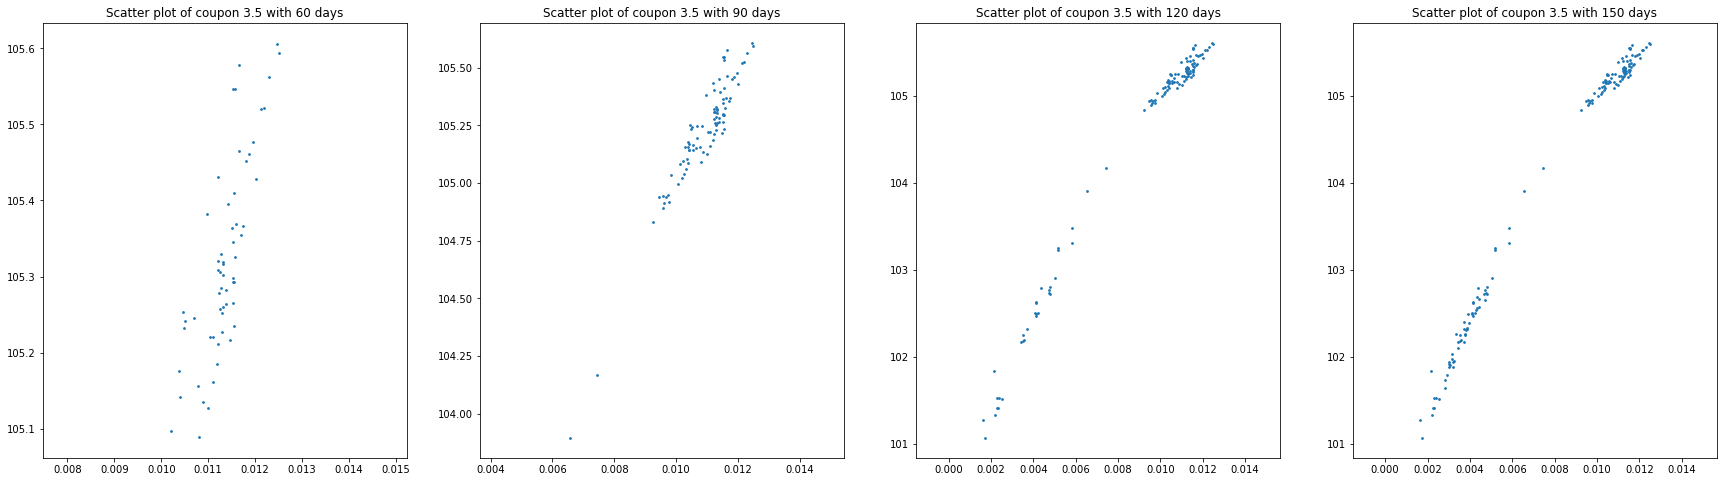

In [8]:
Poly_Window(TBAs,3.5,"2016-07-06",4)

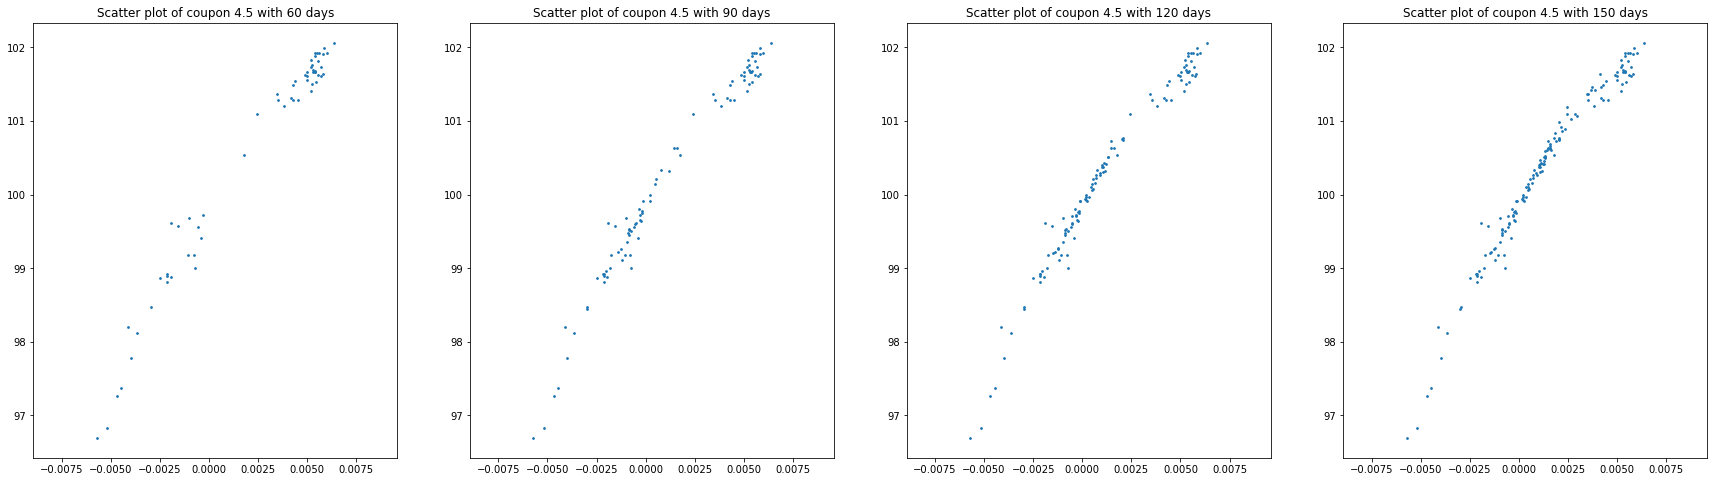

In [9]:
Poly_Window(TBAs,4.5,"2009-04-02",4)

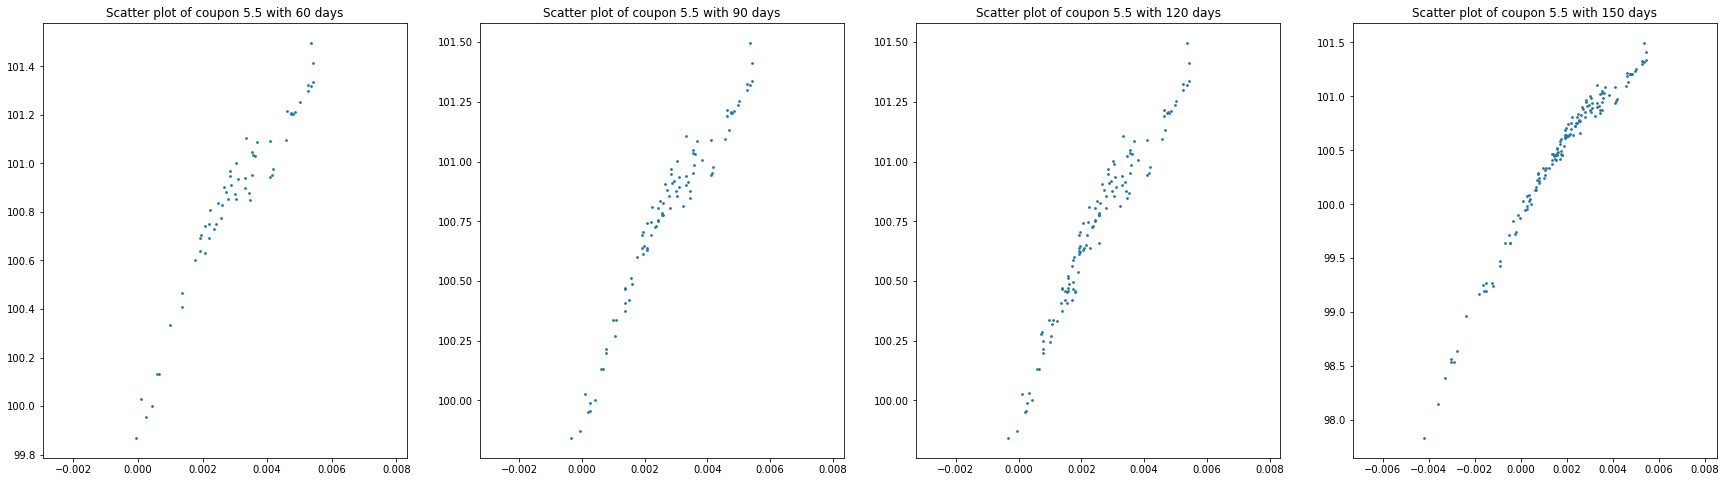

In [10]:
Poly_Window(TBAs,5.5,"2005-04-04",4)

## 2.2. Orthogonal Polynomial Regression - Theory

Orthagonal Polynomial Regression has the form:
$$Y_i=\beta_1\Theta_1(X_i)+\beta_2\Theta_2(X_i)+\text{...} +\beta_k\Theta_k(X_i)+\epsilon$$
where $X_i$ is the after normalized x basis.
<br>
**Step 1**: Normalize $x$ 
$$X=\frac{2x-min(x)-max(x)}{max(x)-min(x)} $$
$X$ is therefore between [-1,1]
<br>
**Step 2**: Transform $X$ to orthgonal basis such as 
$$\sum_i^n=\Theta_r(X_i)\Theta_s(X_i)=0  \text{       where   } r \ne s \text{  for all } r\text{,} s$$
The transformation rule is:
$$\Theta_{r+1}(X)=2(X-a_{r+1})\Theta_r(X)-b_r\Theta_{r-1}(X)$$
where $\Theta_0(X)=1$ , $\Theta_1(X)=2(X-a_1)$
$$a_{r+1}=\frac{\sum_i^nX_i\Theta_r^2(X_i)}{\sum_i^n\Theta_r^2(X_i)}$$
$$b_{r}=\frac{\sum_i^n \Theta_r^2(X_i)}{\sum_i^n\Theta_{r-1}^2(X_i)}$$
with $b_0=0$, $a_1=\bar X$
<br>
Given the data, we would see $a_i$,$b_i$ are constants.
<br>
**Step 3**: Fitting linear regression to the orthogonal basis to get the coefficients, revert the basis.
<br>
Orthogonal Polynomial Regression with degree of two:

$$
\begin{bmatrix}
    1      & 2(X_1-a_1) & 2(X_1-a_2)2(X_1-a_1)-b_1 \\
    1      & 2(X_2-a_1) & 2(X_2-a_2)2(X_2-a_1)-b_1 \\
    \text{...} \\
    1      & 2(X_n-a_1) & 2(X_n-a_2)2(X_n-a_1)-b_1
\end{bmatrix}
\begin{bmatrix}
    \beta_1 \\
    \beta_2 \\
   \beta_3
\end{bmatrix}
=
\begin{bmatrix}
    y_1 \\
    y_2 \\
    \text{...} \\
   y_n
\end{bmatrix}
$$

After simplify:

$$
\begin{bmatrix}
    1      & X_1 & X_1^2 \\
    1      & X_2 & X_2^2\\
    \text{...} \\
    1      & X_n & X_n^2
\end{bmatrix}
\begin{bmatrix}
    \beta_1+\beta_2 a_1-4\beta_3 a_1 a_2 -b_1\beta_3 \\
    2\beta_2 +4\beta_3(a_1+a_2) \\
    4\beta_3
\end{bmatrix}
=
\begin{bmatrix}
    y_1 \\
    y_2 \\
    \text{...} \\
   y_n
\end{bmatrix}
$$

In this case, with different time window, we will have different $\beta$, $a$,$b$. This linear regression's coefficients are time-dependent.

## 2.3. Implementation

In [11]:
def norm_base(x):
    return (2*x-np.min(x)-np.max(x))/(np.max(x)-np.min(x))

In [12]:
def orth_base(x_n,degree):
    #Creating matrix given the required degree
    Z=np.zeros((len(x_n), degree + 1))
    a=np.zeros(degree+1)
    b=np.zeros(degree)
    Z[:,0]=1
    b[0]=0
    a[0]=0
    a[1]=np.mean(x_n)
    Z[:,1]=2*(x_n-a[0])
    for i in range(2,degree+1):
        a[i-1]=np.sum(np.multiply(x_n,np.multiply(Z[:,i-1],Z[:,i-1])))/np.sum(np.multiply(Z[:,i-1],Z[:,i-1]))
        b[i-1]=np.sum(np.multiply(Z[:,i-1],Z[:,i-1]))/np.sum(np.multiply(Z[:,i-2],Z[:,i-2]))
        Z[:,i]=2*np.multiply((x_n-a[i-1]),Z[:,i-1])-b[i-1]*Z[:,i-2]
    return Z.squeeze(),a,b

In [13]:
def fitting_OLS(reg_Y,reg_X):
    mod = sm.OLS(reg_Y, reg_X)
    res = mod.fit()
    return res.params

In [14]:
def duration_from_ortho_poly_fit(X, Y, deg, rate):
    
    coef = np.array(fitting_OLS(Y, X))
    
    delta = 0.0001
    rate_plus = rate + delta
    rate_minus = rate - delta
    
    x_plus,a,b = orth_base(np.array([rate_plus]), deg)
    x_minus,a,b = orth_base(np.array([rate_minus]), deg)
    
    price_plus = np.sum(coef * x_plus)
    price_minus = np.sum(coef * x_minus)
    
    return - (price_plus - price_minus) / (delta * 2)

In [15]:
def regression_poly_wind_V2(wind, X, Y, deg, ploy_fit_func, rate):
    if(len(X) != len(Y)):
        raise Exception('X and Y should have same length')
    if(len(X) < wind):
        raise Exception('Rolling window size should be larger than data size')
    
    beta = []
    pure_X = X
    pure_Y = Y
    
    for i in range((len(X)-wind)):
        reg_X = pure_X[i:i + wind]
        reg_Y = pure_Y[i:i + wind]
        beta.append(ploy_fit_func(reg_X, reg_Y, deg, rate))
        
    return beta

In [16]:
default_window = 60
degree = 1

poly_duration_without_order = {}
for c, period_list in collapse_without_order.items():
    dat = TBAs[c]
    default_start_date = min(dat.index)
    
    cur_list = []
    for p in period_list:
        window = default_window
        
        reg_start_date = p.startDate - dt.timedelta(days = window)
        if reg_start_date < default_start_date:
            reg_start_date = default_start_date
        
        rolling_period = len(dat[reg_start_date:p.endDate]['price'])
        if rolling_period < window:
            window = rolling_period // 2 + 1
        
        # normalize X
        rates = norm_base(dat[reg_start_date:p.endDate]['MTGFNCL'])
        
        # transform X to orthogonal basis
        reg_X, a, b = orth_base(rates, degree)
        
        betas = regression_poly_wind_V2(window, reg_X, dat[reg_start_date:p.endDate]['price'], degree, duration_from_ortho_poly_fit, rates[len(rates) - 1])
        
        
        cur_list.append(pd.DataFrame({'Duration': betas}, index = rates.index[window:]))
        
    poly_duration_without_order[c] = cur_list

In [17]:
def getUniqLabel(handles, labels):
    uniq_label= {}
    for idx, lab in enumerate(labels):
        if lab not in uniq_label.keys():
            uniq_label[lab] = handles[idx]
    return uniq_label

color_code = {
    2.5: 'red',
    3.0: 'orange',
    3.5: 'yellow',
    4.0: 'green',
    4.5: 'cyan',
    5.0: 'blue',
    5.5: 'purple',
    6.0: 'gold',
    6.5: 'olive',
    7.0: 'brown',
    7.5: 'khaki',
    8.0: 'mediumslateblue',
    
}

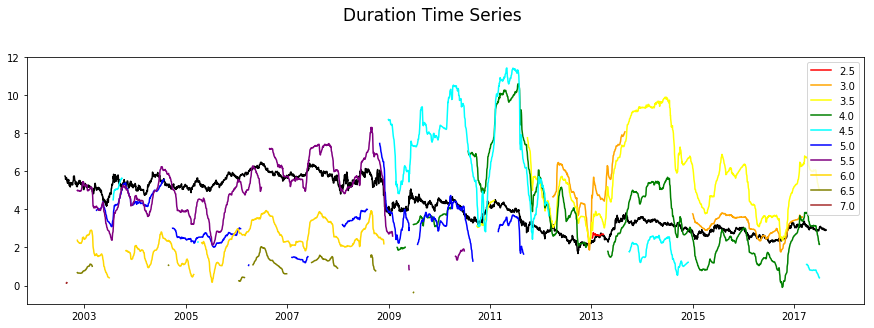

In [18]:
fig = plt.figure(figsize = (15,10))
plt.suptitle('Duration Time Series', y=0.95, fontsize=17)
ax = fig.add_subplot(211)
ax.plot(rate_Base.index, rate_Base['MTGFNCL'].values, color = 'black')
for c, duration_list in poly_duration_without_order.items():
    for d in duration_list:
        ax.plot(d.index, d.Duration, c = color_code[c],label=c)
handles, labels = ax.get_legend_handles_labels()
uniq_label=getUniqLabel(handles, labels)
plt.legend(uniq_label.values(),uniq_label.keys()) 

# 3. Measure performance of beta in hedging

Using 1y, 5y and 10y treasury as the heding instruments.

step 1) using regression to calculate partial duration for 1y, 5y and 10 treasury

$$-\dfrac{\Delta P}{P}=D_{10}\Delta r_{10}+D_{5}\Delta r_{5}+D_{1}\Delta r_{1}+\epsilon$$

step 2) construct hedged portfolio 

$$HR_i=\dfrac{D_{i}P_{TBA}}{D_{\text{i year note}}P_{\text{i year note}}}\\
\Pi = TBAs - \sum  HR_i \times \text{i year note}$$

step 3) compare the return and variance between the portfolio and naked position

\* dummy data is used for below code construction

### 3.1 calculate partial duration

In [19]:
def regression_partial_wind(wind, X10, X5, X1 , Y):
    
    if(len(X10) != len(Y) or len(X5) != len(Y) or len(X1) != len(Y)):
        raise Exception('X and Y should have same length')
    if(len(X10) < wind or len(X5) < wind or len(X1) < wind):
        raise Exception('Rolling window size should be larger than data size')
        
    beta10,beta5,beta1 = [],[],[]
    
    pure_X10 = np.array(X10.values)
    pure_X5 = np.array(X5.values)
    pure_X1 = X1.values
    pure_Y = Y.values
    index = X10.index[wind:]
    
    pure_X=np.vstack((pure_X10,pure_X5,pure_X1)).T
    
    for i in range(len(X10)-wind):
        reg_X = pure_X[i:i + wind,:]
        reg_Y = pure_Y[i:i + wind]
        
        mod = sm.OLS(reg_Y, reg_X)
        res = mod.fit()
        b = res.params
        
        beta10.append(b[0])
        beta5.append(b[1])
        beta1.append(b[2])
        
    return pd.DataFrame({'Duration10': beta10,'Duration5': beta5,'Duration1': beta1}, index = index)

In [20]:
default_window = 60

partial_duration = {}
for c, period_list in collapse_without_order.items():
    dat = TBAs[c]
    default_start_date = min(dat.index)
    
    cur_list = []
    for p in period_list:
        window = default_window
        
        reg_start_date = p.startDate - dt.timedelta(days = window)
        if reg_start_date < default_start_date:
            reg_start_date = default_start_date
        
        rolling_period = len(dat[reg_start_date:p.endDate]['price'])
        if rolling_period < window:
            window = rolling_period // 2 + 1
            
        betas = regression_partial_wind(window, dat[reg_start_date:p.endDate]['MTGFNCL'],\
                                        dat[reg_start_date:p.endDate]['MTGFNCL']-1,\
                                        dat[reg_start_date:p.endDate]['MTGFNCL']-2,\
                                        dat[reg_start_date:p.endDate]['price'])
        
        #for coding purpose use dat[reg_start_date:p.endDate]['MTGFNCL'] as 10y treasury
        #                       dat[reg_start_date:p.endDate]['MTGFNCL']-1 as 5y treasury
        #                       dat[reg_start_date:p.endDate]['MTGFNCL']-2 as 1y treasury
        cur_list.append(betas)
        
    partial_duration[c] = cur_list

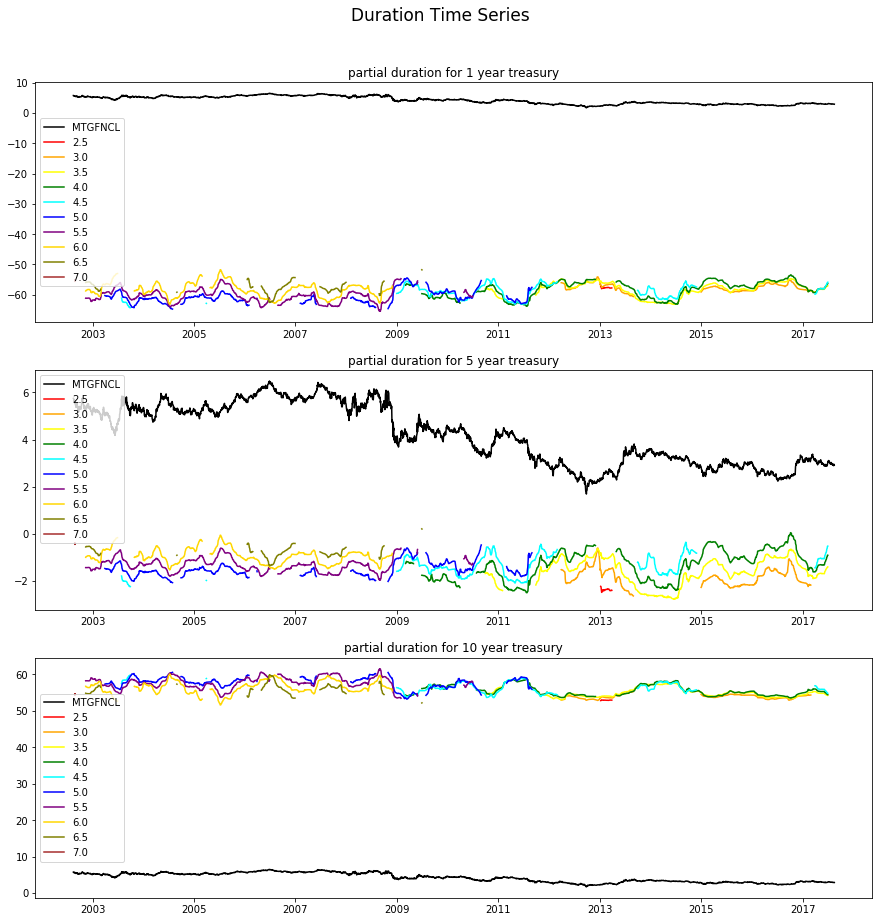

In [21]:
plt.figure(figsize = (15,15))
plt.suptitle('Duration Time Series', y=0.95, fontsize=17)
instrument =['1','5','10']
for i, thisInstr in enumerate(instrument):
    ax=plt.subplot(len(instrument),1,i+1)
    plt.title('partial duration for '+thisInstr+' year treasury')
    plt.plot(rate_Base.index, rate_Base['MTGFNCL'].values, color = 'black',label='MTGFNCL')
    for c, duration_list in partial_duration.items():
        for d in duration_list:
            plt.plot(d.index, d['Duration'+thisInstr], c = color_code[c], label=c)
    handles, labels = ax.get_legend_handles_labels()
    uniq_label=getUniqLabel(handles, labels)
    plt.legend(uniq_label.values(),uniq_label.keys()) 

### 3.2 Plot Hedged Ratio

In [22]:
tbill = pd.read_excel( 'tbill.xlsx',index_col=0, header=0)
tbill.head()

,Open,High,Low,Close,1y,5y,10y
Date,,,,,,,
2017-08-22,1.224,1.250,1.216,1.239,98.768644,99.768644,100.768644
2017-08-21,1.237,1.247,1.211,1.226,98.781485,99.781485,100.781485
2017-08-18,1.237,1.255,1.218,1.239,98.768644,99.768644,100.768644
2017-08-17,1.250,1.263,1.224,1.229,98.778521,99.778521,100.778521
2017-08-16,1.234,1.273,1.232,1.252,98.755805,99.755805,100.755805


In [23]:
startDate=tbill.index[-1]
result=[]
for c in partial_duration.keys(): #iterate for all coupons
    for item in partial_duration[c]: #iterate for all windows
        hedge=pd.DataFrame(item)
        for i,dataDate in enumerate(hedge.index):
            if dataDate >= startDate and len(hedge.index[i:])>1:
                hedgeUse=hedge[i:]
                nakedR=[np.nan]
                portfolioR=[np.nan]
                hr1,hr5,hr10=[np.nan],[np.nan],[np.nan]
                d0=hedgeUse.index[0]
                for j,d in enumerate(hedgeUse.index[1:]):
                    try:
                        nakedReturn = (TBAs[c].price[d]-TBAs[c].price[d0])/TBAs[c].price[d0]
                        hedgeRatio1=(hedgeUse['Duration1'][d0]*TBAs[c].price[d0])/(1*float(tbill['1y'][d0])) 
                        #duration of 1y ZCB is 1 for coding purpose
                        hedgeRatio5=(hedgeUse['Duration5'][d0]*TBAs[c].price[d0])/(5*float(tbill['5y'][d0])) 
                        #duration of 5y ZCB is 5 for coding purpose
                        hedgeRatio10=(hedgeUse['Duration10'][d0]*TBAs[c].price[d0])/(10*float(tbill['10y'][d0])) 
                        #duration of 10y ZCB is 10 for coding purpose
                        pt=TBAs[c].price[d]-hedgeRatio1*float(tbill['1y'][d])-hedgeRatio5*float(tbill['5y'][d])-\
                           hedgeRatio10*float(tbill['10y'][d])
                        pt0=TBAs[c].price[d0]-hedgeRatio1*float(tbill['1y'][d0])-hedgeRatio5*float(tbill['5y'][d0])-\
                           hedgeRatio10*float(tbill['10y'][d0])
                        hedgedReturn=(pt-pt0)/pt0
                    except:  
                        nakedReturn=np.nan
                        hedgeRatio1,hedgeRatio5,hedgeRatio10=np.nan,np.nan,np.nan
                        hedgedReturn=np.nan
                    nakedR.append(nakedReturn)
                    portfolioR.append(hedgedReturn)
                    hr1.append(hedgeRatio1)
                    hr5.append(hedgeRatio5)
                    hr10.append(hedgeRatio10)
                    d0=d
                hedgeUse['hedge_Ratio1']=hr1
                hedgeUse['hedge_Ratio5']=hr5
                hedgeUse['hedge_Ratio10']=hr10
                hedgeUse['naked_return']=nakedR
                hedgeUse['hedged_return']=portfolioR
                result.append([c,hedgeUse])
                break

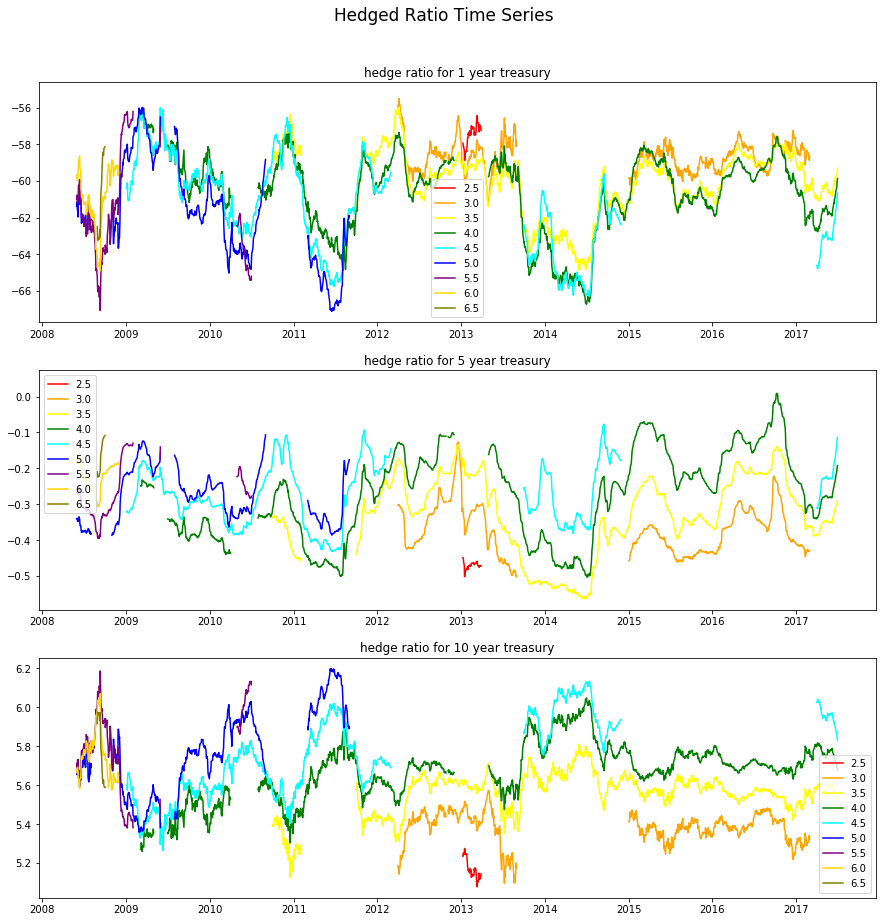

In [24]:
fig = plt.figure(figsize = (15,15))
plt.suptitle('Hedged Ratio Time Series', y=0.95, fontsize=17)
instrument =['1','5','10']
for i, thisInstr in enumerate(instrument):
    ax = plt.subplot(len(instrument),1,i+1)
    plt.title('hedge ratio for '+thisInstr+' year treasury')
    for c, hedge_list in result:
        ax.plot(hedge_list.index, hedge_list['hedge_Ratio'+thisInstr], c = color_code[c],label=c)
    handles, labels = ax.get_legend_handles_labels()
    uniq_label=getUniqLabel(handles, labels)
    plt.legend(uniq_label.values(),uniq_label.keys()) 

### 3.3 Plot Hedging Performance

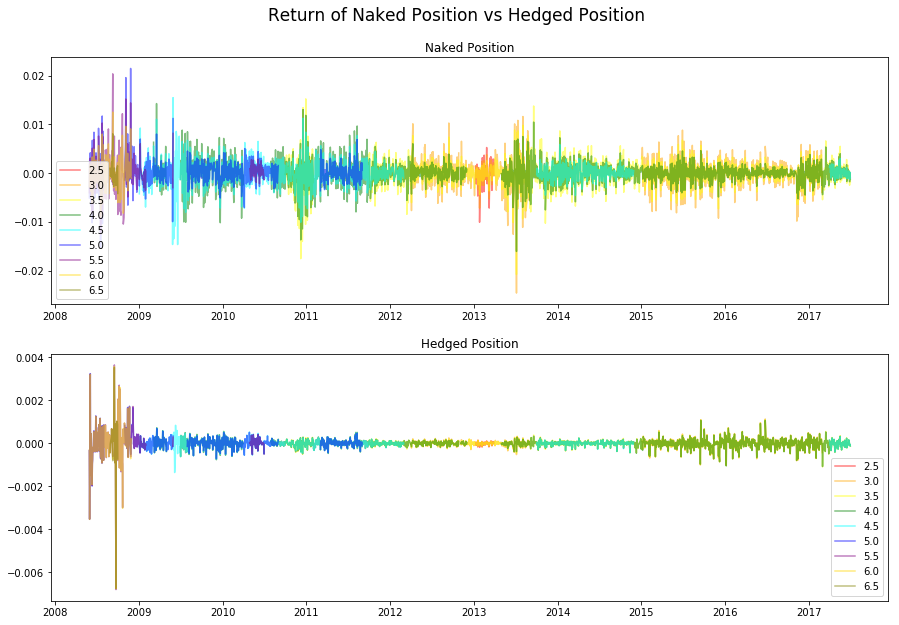

In [25]:
fig = plt.figure(figsize = (15,10))
plt.suptitle('Return of Naked Position vs Hedged Position', y=0.95, fontsize=17)
ax = fig.add_subplot(211)
for c, hedge_list in result:
    ax.plot(hedge_list.index, hedge_list['naked_return'], alpha=0.5,c = color_code[c],label=c)
handles, labels = ax.get_legend_handles_labels()
uniq_label=getUniqLabel(handles, labels)
plt.legend(uniq_label.values(),uniq_label.keys()) 
plt.title('Naked Position')

ax = fig.add_subplot(212)
for c, hedge_list in result:
    ax.plot(hedge_list.index, hedge_list['hedged_return'], alpha=0.5,c = color_code[c],label=c)
handles, labels = ax.get_legend_handles_labels()
uniq_label=getUniqLabel(handles, labels)
plt.legend(uniq_label.values(),uniq_label.keys()) 
plt.title('Hedged Position')